In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

In [2]:
df1 = pd.read_csv("./rsivl_features.csv")
df2 = pd.read_pickle("./rsivl_dataframe.p")

In [3]:
df2["filename"] = df2["filename"].apply(lambda x: x[:-4])
df2 = df2.sort_values("filename")
df1 = df1[df1["image"] != "imm(20)"]
df2 = df2.drop(["4points", "8points", "16points", "32points","64points", "complexity", "computed_average"], axis=1)
df1 = df1.rename(columns={"complexity_rating": "complexity_paper_averages"})

In [4]:
df = pd.concat([df1.set_index('image'), df2.set_index('filename')], axis=1, join='inner')
df.shape

(48, 47)

In [5]:
df.to_pickle("./rsivl_df.p")

# Remove Outliers

In [6]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df["complexity_no_outliers"] = df[["participant{}".format(i) for i in participants]].mean(axis=1)

In [7]:
def report_correlations(x, y):
    model = np.poly1d(np.polyfit(x, y, 1))
    print(stats.pearsonr(x, y), stats.spearmanr(x, y), r2_score(y, model(x)))

In [8]:
report_correlations(df["complexity_no_outliers"], df["num_seg_5"])
report_correlations(df["complexity_paper_averages"], df["num_seg_5"])

PearsonRResult(statistic=0.8136533241719136, pvalue=2.0768286515301878e-12) SignificanceResult(statistic=0.8544013541949153, pvalue=1.1338527673483075e-14) 0.6620317319360052
PearsonRResult(statistic=0.801299748620105, pvalue=7.880184101010334e-12) SignificanceResult(statistic=0.8257966560844093, pvalue=5.068811125204044e-13) 0.6420812871386434


In [9]:
report_correlations(df["complexity_no_outliers"], df["num_seg_4"])
report_correlations(df["complexity_paper_averages"], df["num_seg_4"])

PearsonRResult(statistic=0.8263863345556859, pvalue=4.720308743852751e-13) SignificanceResult(statistic=0.8365723951375125, pvalue=1.319976800796185e-13) 0.6829143739403822
PearsonRResult(statistic=0.8109511051285976, pvalue=2.803316773355055e-12) SignificanceResult(statistic=0.8034633518605167, pvalue=6.2815358306266105e-12) 0.6576416949092938


# Visualization

In [10]:
def rank_xform(c):
    return c.rank(axis=0, method="average")

def sqrt_xform(c):
    return np.sqrt(c)

In [11]:
def plot_scatter(x, y):
    plt.scatter(x, y);
    model = np.poly1d(np.polyfit(x, y, 1))
    plt.plot(x, model(x), color="r", label="Pearson {:.3f}, R^2 {:.3f}".format(stats.pearsonr(x, y).statistic, r2_score(y, model(x))))
    plt.legend()

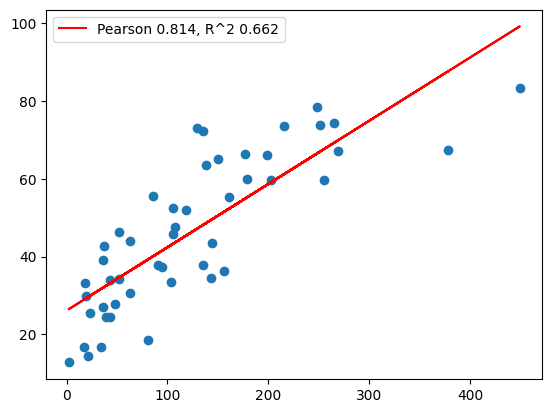

In [12]:
plot_scatter(df["num_seg_5"], df["complexity_no_outliers"])

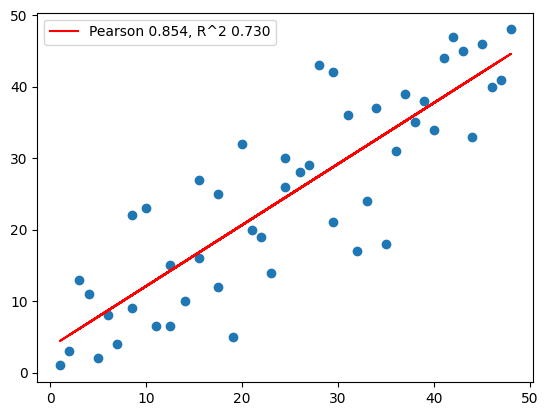

In [13]:
plot_scatter(rank_xform(df["num_seg_5"]), rank_xform(df["complexity_no_outliers"]))

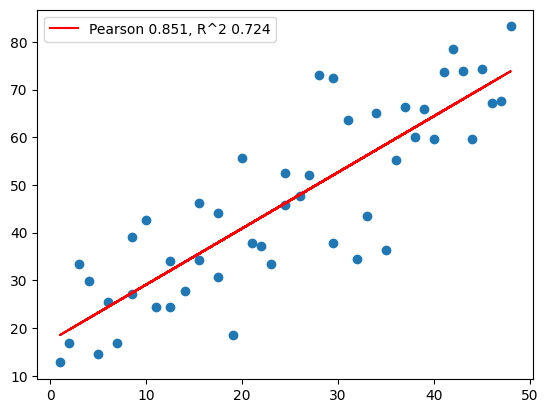

In [14]:
plot_scatter(rank_xform(df["num_seg_5"]), df["complexity_no_outliers"])

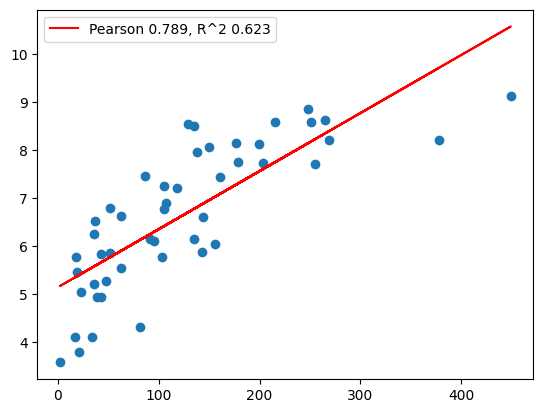

In [15]:
plot_scatter(df["num_seg_5"], sqrt_xform(df["complexity_no_outliers"]))

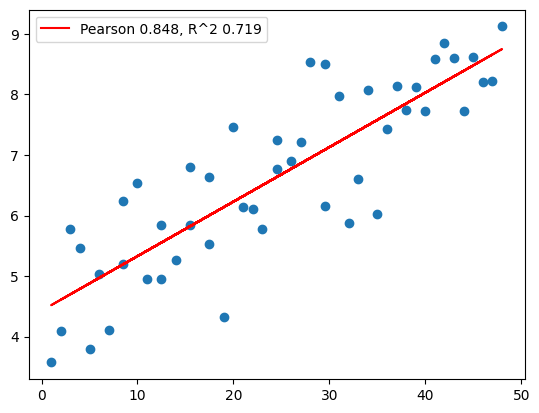

In [16]:
plot_scatter(rank_xform(df["num_seg_5"]), sqrt_xform(df["complexity_no_outliers"]))

# Regression

In [17]:
from sklearn import linear_model

In [54]:
def fit_report_linear(X, y, silent=False):
    model = linear_model.LinearRegression()
    model.fit(X, y)

    betas = model.coef_
    t = stats.pearsonr(y, model.predict(X))
    pearson_stat = t.statistic
    pearson_p = t.pvalue
    t = stats.spearmanr(y, model.predict(X))
    spearman_stat = t.statistic
    spearman_p = t.pvalue
    r2 = r2_score(y, model.predict(X))

    if not silent:
        print("Pearson: {:.3f} p={}, Spearman: {:.3f} p={}, R^2: {:.3f}".format(
            pearson_stat, pearson_p, spearman_stat, spearman_p, r2
        ))

    return pearson_stat, pearson_p, spearman_stat, spearman_p, r2, betas    

## Try other levels

In [26]:
X, y = df[["num_seg_5"]], df["complexity_no_outliers"]
fit_report_linear(X, y);

Pearson: 0.814 p=2.0768286515301878e-12, Spearman: 0.854 p=1.1338527673483075e-14, R^2: 0.662


In [27]:
X, y = df[["num_seg_5", "num_seg_3"]], df["complexity_no_outliers"]
fit_report_linear(X, y);

Pearson: 0.818 p=1.2581566368372494e-12, Spearman: 0.849 p=2.5653500550835008e-14, R^2: 0.669


In [21]:
X, y = rank_xform(df[["num_seg_5"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_5", "num_seg_4"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_5", "num_seg_3"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_5", "num_seg_2"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_5", "num_seg_1"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)

Pearson: 0.851 p=1.8699768133554217e-14, Spearman: 0.854 p=1.1338527673483075e-14, R^2: 0.724
Pearson: 0.852 p=1.6944671997773976e-14, Spearman: 0.855 p=1.064319233929032e-14, R^2: 0.725
Pearson: 0.855 p=1.003771755713466e-14, Spearman: 0.861 p=3.939699116447882e-15, R^2: 0.731
Pearson: 0.853 p=1.3355982724668381e-14, Spearman: 0.855 p=1.0558510008915021e-14, R^2: 0.728
Pearson: 0.852 p=1.602329725123912e-14, Spearman: 0.861 p=4.3902965866684394e-15, R^2: 0.726


In [22]:
X, y = pd.concat([rank_xform(df["num_seg_5"]), df["num_seg_3"]], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)

Pearson: 0.852 p=1.6773874828049676e-14, Spearman: 0.858 p=6.37451322433322e-15, R^2: 0.725


## Try segment labels

In [34]:
df["temp"] = rank_xform(df["num_seg_5"]) * rank_xform(df["num_unique_seglabels"])

X, y = rank_xform(df[["num_seg_5"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df["num_seg_5"]), df["num_unique_seglabels"]], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df["num_seg_5"]), df["num_unique_seglabels"], rank_xform(df["temp"])], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df["num_seg_5"]), rank_xform(df["num_unique_seglabels"]), rank_xform(df["temp"])], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_5", "num_unique_seglabels"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["temp"]]), df["complexity_no_outliers"]
fit_report_linear(X, y);

Pearson: 0.851 p=1.8699768133554217e-14, Spearman: 0.854 p=1.1338527673483075e-14, R^2: 0.724
Pearson: 0.870 p=9.375449037731566e-16, Spearman: 0.877 p=3.1798898283443674e-16, R^2: 0.758
Pearson: 0.882 p=1.3073411895762442e-16, Spearman: 0.881 p=1.4488675505493202e-16, R^2: 0.777
Pearson: 0.882 p=1.2961955761244934e-16, Spearman: 0.881 p=1.4488675505493202e-16, R^2: 0.777
Pearson: 0.880 p=1.841495878432384e-16, Spearman: 0.885 p=6.733927408765301e-17, R^2: 0.774
Pearson: 0.880 p=1.7599914719194871e-16, Spearman: 0.885 p=6.873645833439168e-17, R^2: 0.774


In [36]:
X, y = rank_xform(df[["num_seg_4"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df["num_seg_4"]), df["num_unique_seglabels"]], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df["num_seg_4"]), df["num_unique_seglabels"], rank_xform(df["temp"])], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y);

Pearson: 0.834 p=1.787562176519912e-13, Spearman: 0.837 p=1.319976800796185e-13, R^2: 0.696
Pearson: 0.858 p=6.163972393043765e-15, Spearman: 0.856 p=9.481595559044228e-15, R^2: 0.737
Pearson: 0.880 p=1.6197534390121236e-16, Spearman: 0.885 p=6.46255244395703e-17, R^2: 0.775


In [46]:
X, y = pd.concat([rank_xform(df["num_seg_4"]), df["semsim"]], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_4", "semsim"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = rank_xform(df[["num_seg_4", "num_unique_seglabels", "semsim"]]), df["complexity_no_outliers"]
fit_report_linear(X, y)
X, y = pd.concat([rank_xform(df[["num_seg_4", "num_unique_seglabels"]]), df["semsim"]], axis=1), df["complexity_no_outliers"]
fit_report_linear(X, y);

Pearson: 0.843 p=5.777150847672629e-14, Spearman: 0.850 p=2.1728442593098078e-14, R^2: 0.710
Pearson: 0.836 p=1.453868487275075e-13, Spearman: 0.839 p=9.989543872154156e-14, R^2: 0.699
Pearson: 0.871 p=7.916403734226042e-16, Spearman: 0.873 p=6.182001818535199e-16, R^2: 0.759
Pearson: 0.872 p=7.753509540858155e-16, Spearman: 0.870 p=9.317785570758853e-16, R^2: 0.760


# Participant Fits

In [88]:
def participant_fit_variable_gain(fixed_variables, test_variables):

    results = {}
    for i in participants:
        results[i] = {}
        
        X = rank_xform(df[fixed_variables])
        y = rank_xform(df["participant{}".format(i)])
        results[i]["baseline"] = fit_report_linear(X, y, silent=True)

        for v in test_variables:
            X = rank_xform(df[fixed_variables + [v]])
            results[i][v] = fit_report_linear(X, y, silent=True)

    for v in test_variables:
        # plt.figure()
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        data = [x[v][-2]-x['baseline'][-2] for _, x in results.items()]
        bin_width = 0.005
        axs[0].hist(data, bins=np.arange(min(data), max(data)+bin_width, bin_width))
        axs[1].boxplot(data)
        axs[0].set_title("{} add {}".format(fixed_variables, v))

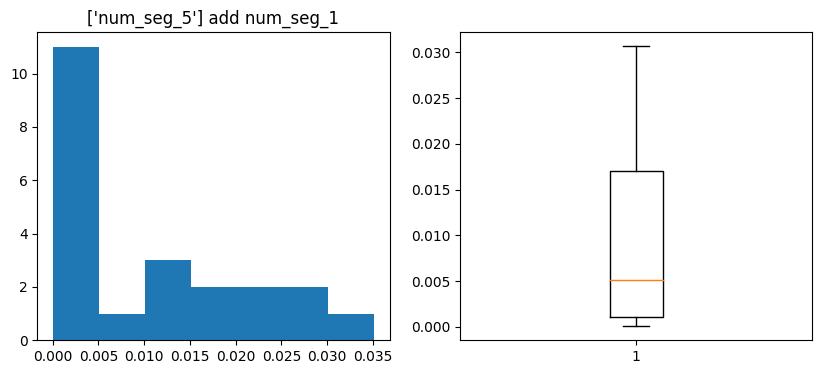

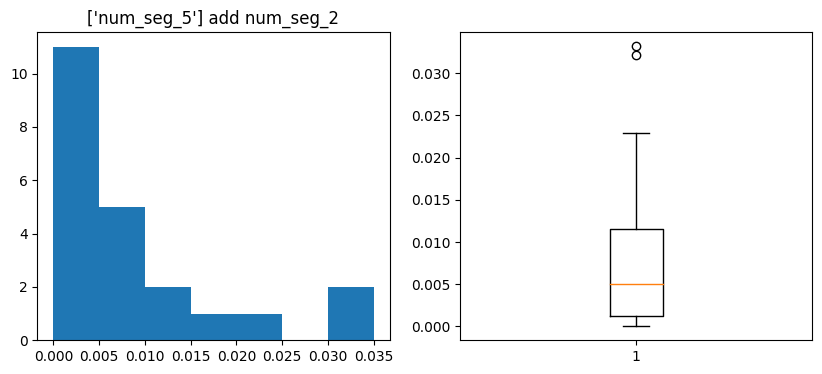

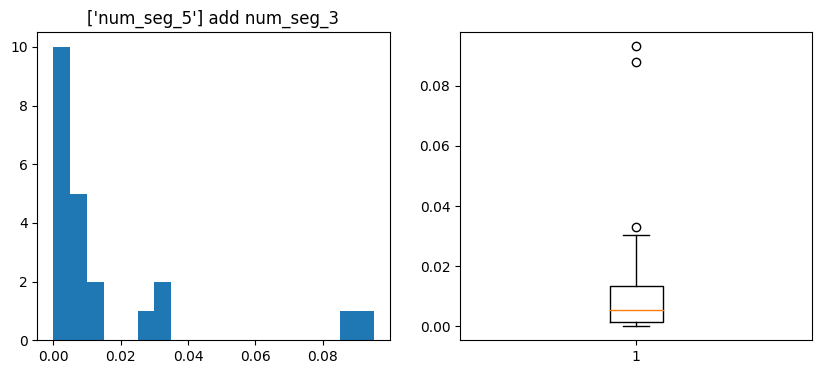

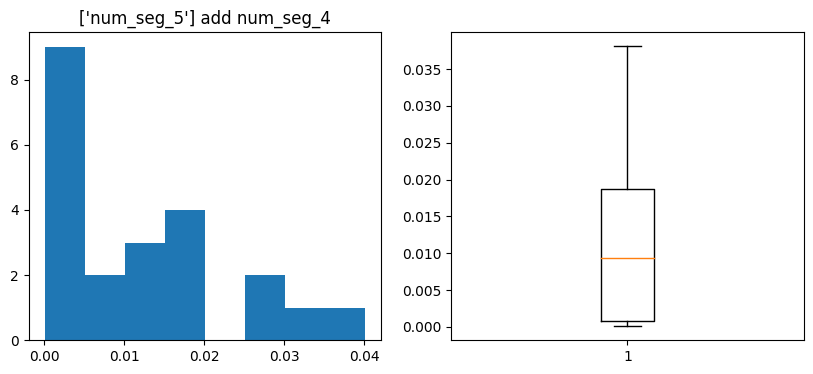

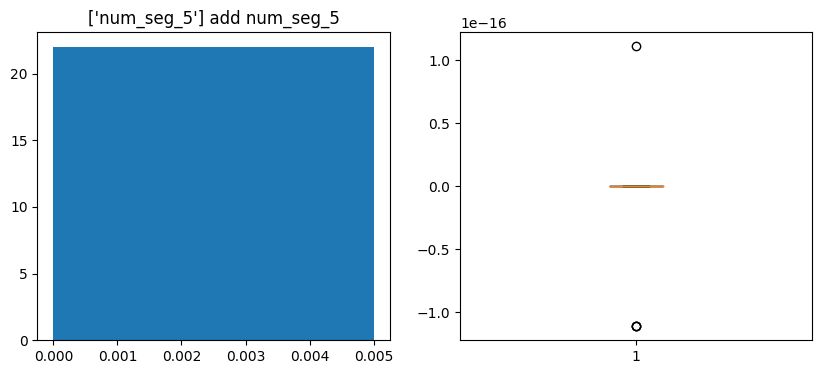

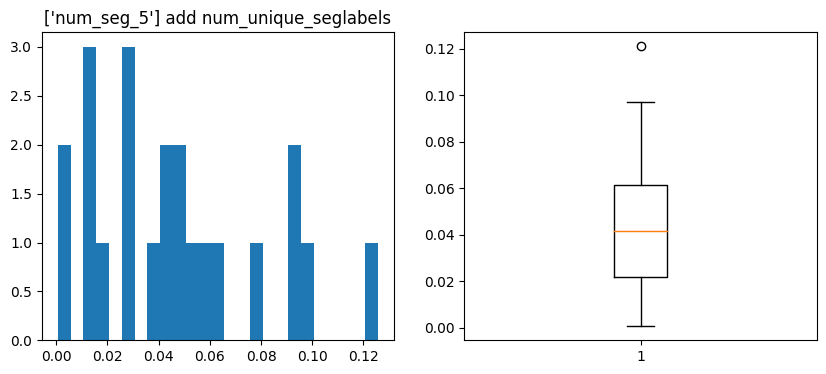

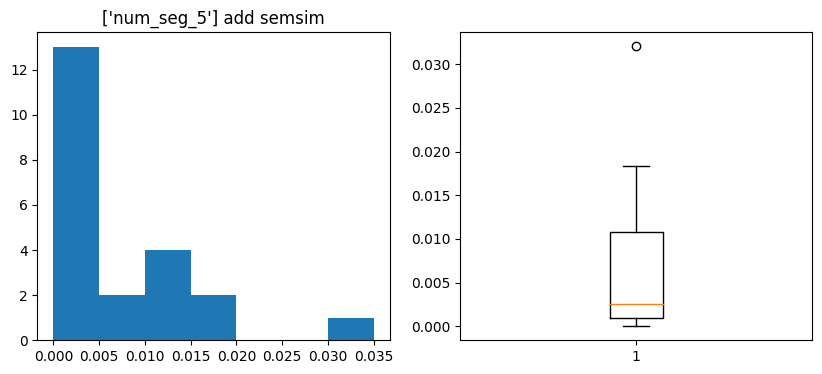

In [93]:
fixed_variables = ["num_seg_5"]
test_variables = ["num_seg_1", "num_seg_2", "num_seg_3", "num_seg_4", "num_seg_5", "num_unique_seglabels", "semsim"]
participant_fit_variable_gain(fixed_variables, test_variables)

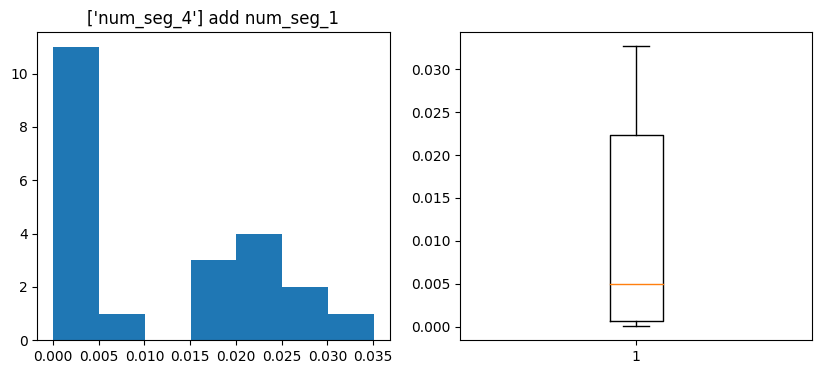

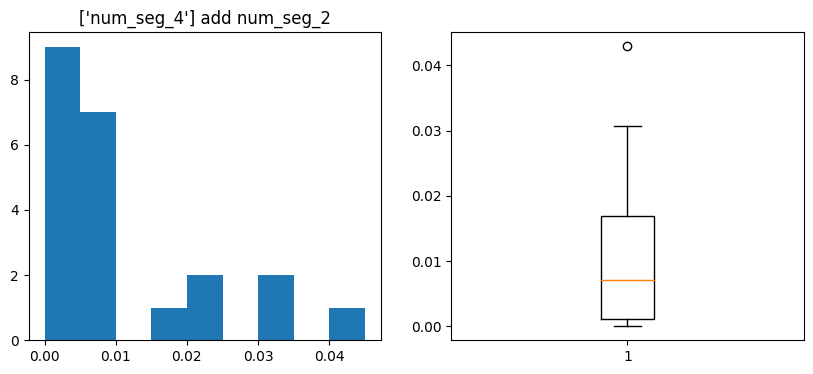

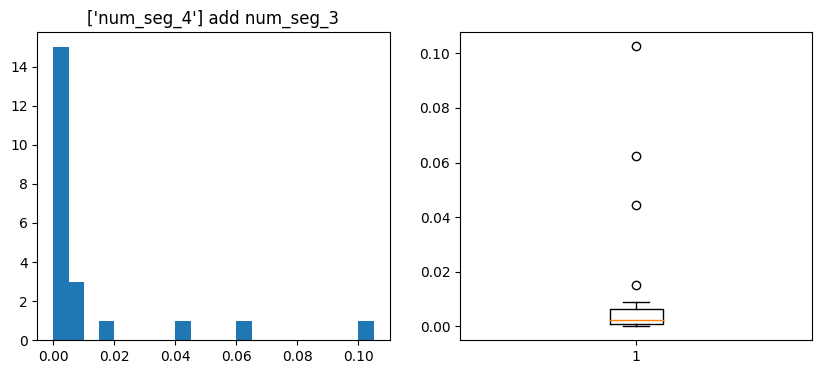

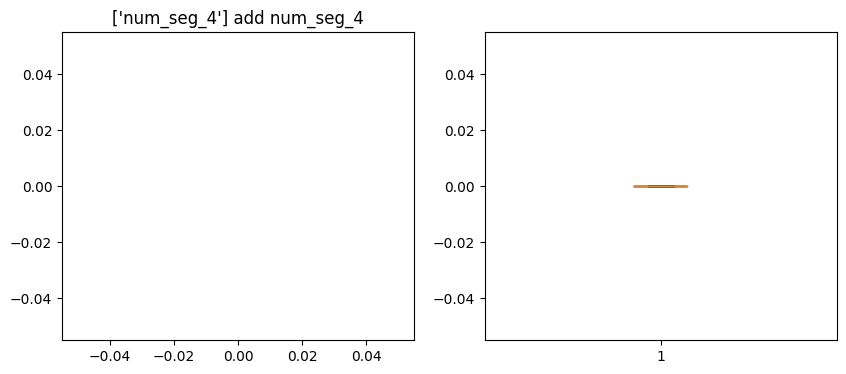

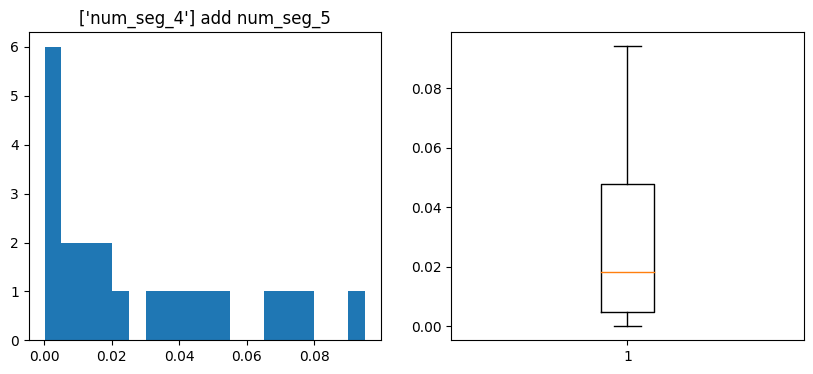

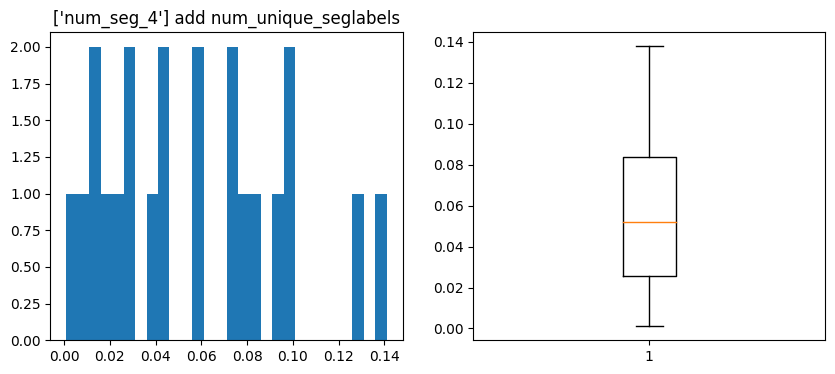

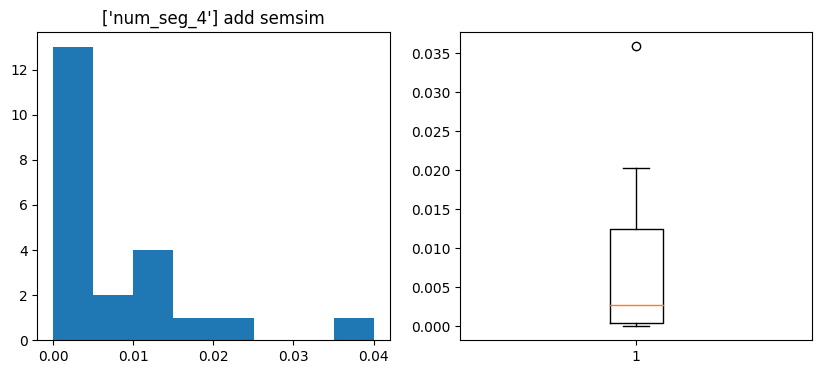

In [94]:
fixed_variables = ["num_seg_4"]
test_variables = ["num_seg_1", "num_seg_2", "num_seg_3", "num_seg_4", "num_seg_5", "num_unique_seglabels", "semsim"]
participant_fit_variable_gain(fixed_variables, test_variables)

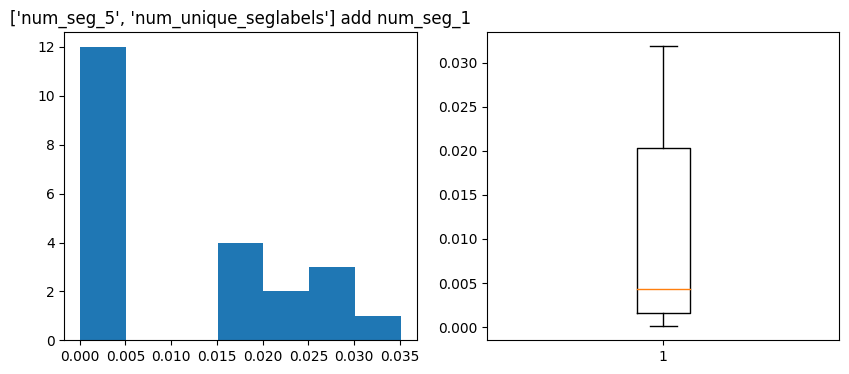

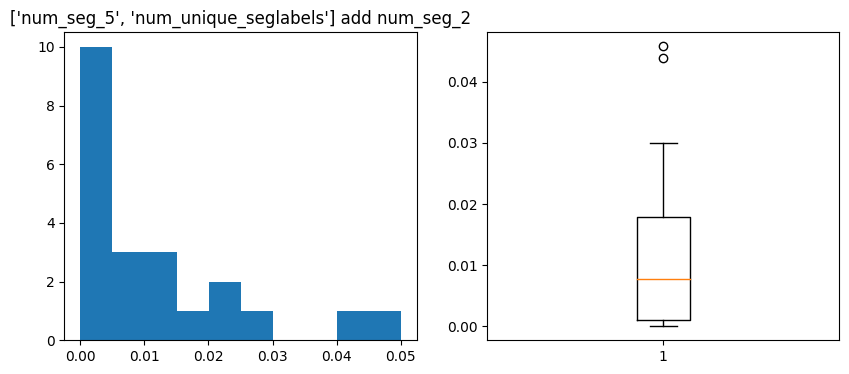

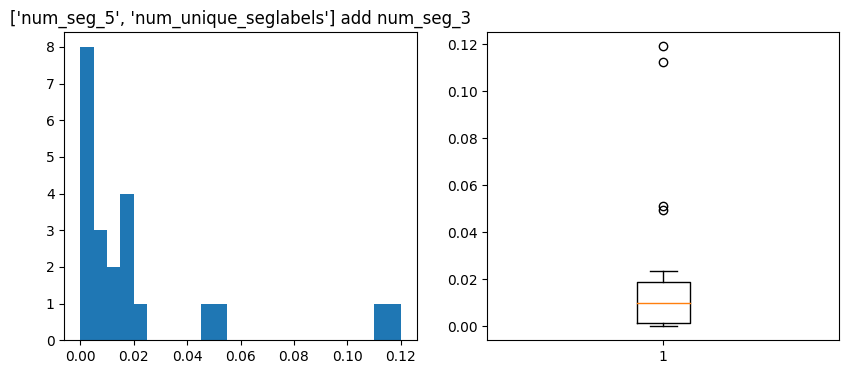

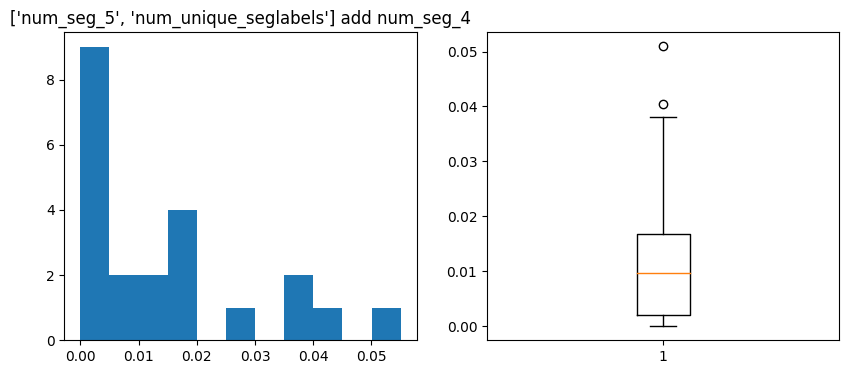

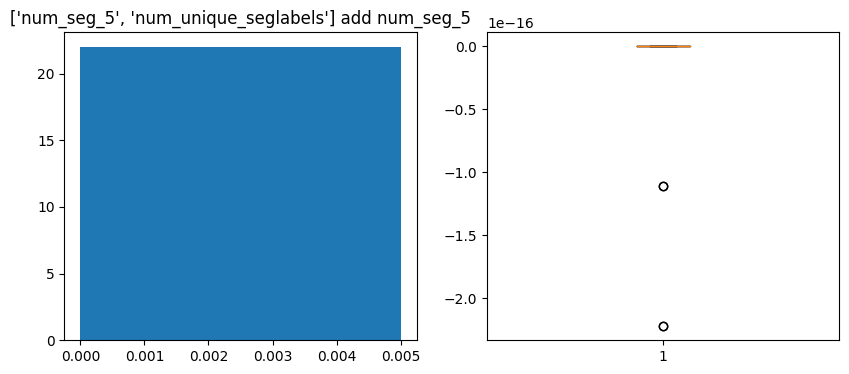

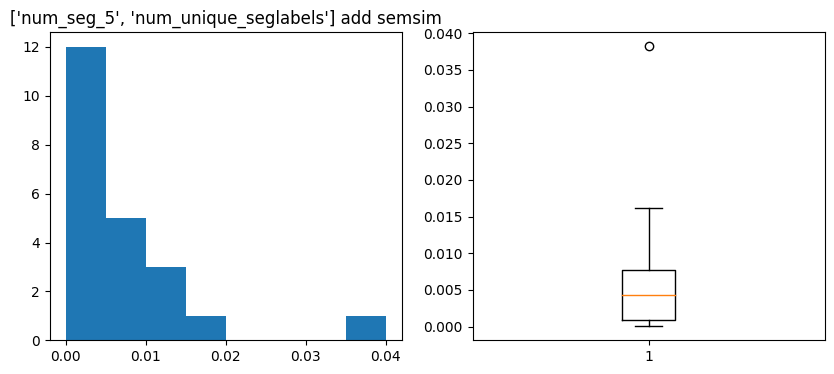

In [96]:
fixed_variables = ["num_seg_5", "num_unique_seglabels"]
test_variables = ["num_seg_1", "num_seg_2", "num_seg_3", "num_seg_4", "num_seg_5", "semsim"]
participant_fit_variable_gain(fixed_variables, test_variables)

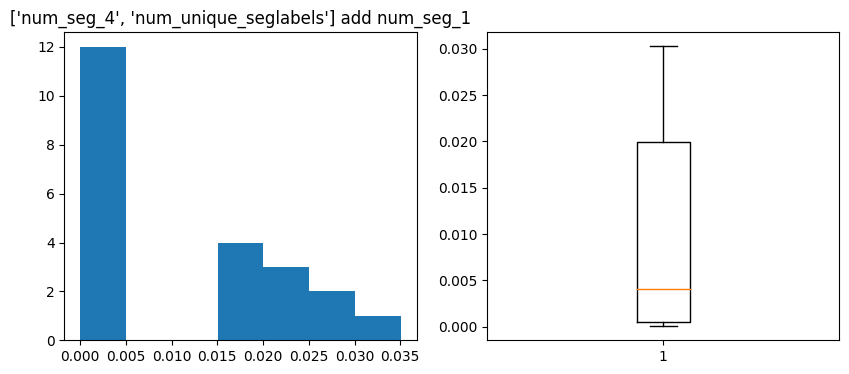

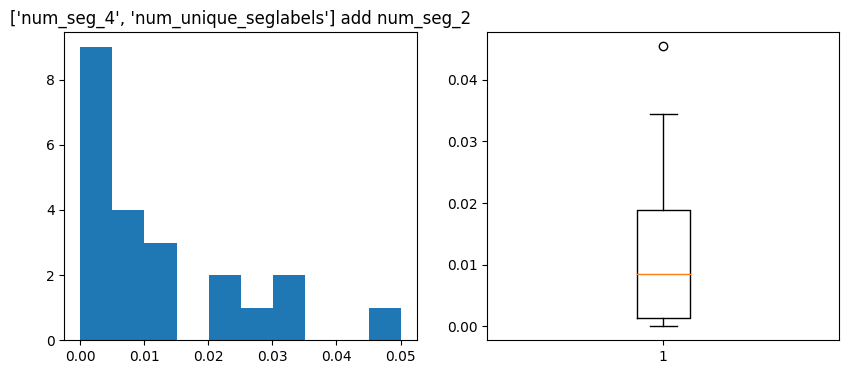

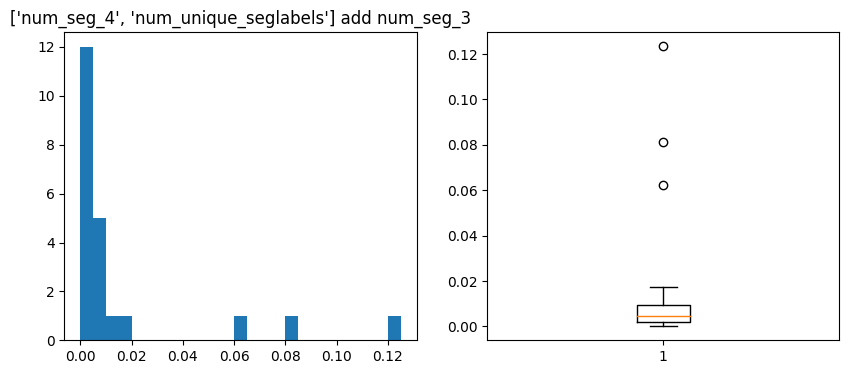

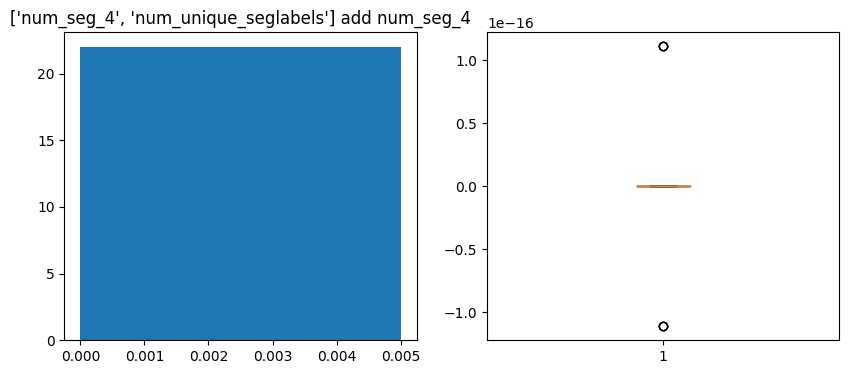

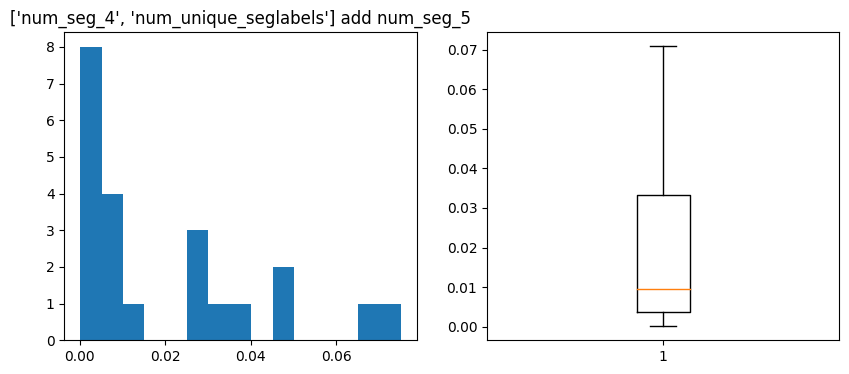

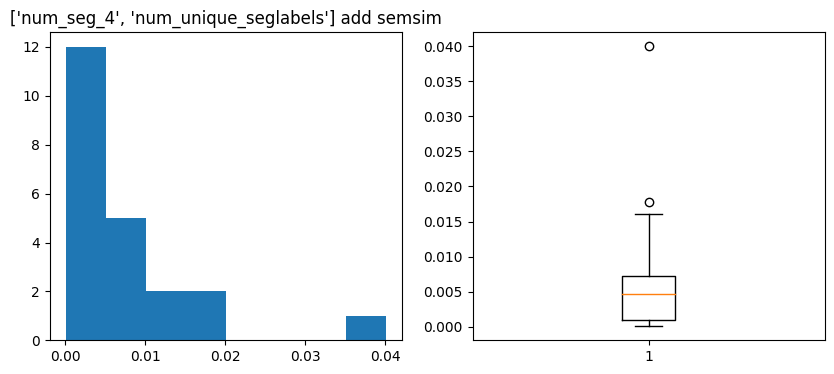

In [97]:
fixed_variables = ["num_seg_4", "num_unique_seglabels"]
test_variables = ["num_seg_1", "num_seg_2", "num_seg_3", "num_seg_4", "num_seg_5", "semsim"]
participant_fit_variable_gain(fixed_variables, test_variables)